In [1]:
import json
import os  # Create directories, list files
import zipfile
import shutil
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mping
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Conv2D, MaxPool2D, Dropout, Flatten, BatchNormalization 
from tensorflow.keras.optimizers import Adam, RMSprop
from sklearn.metrics import classification_report, confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
import time
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [2]:
input_folder="dataset"
base_dir="dataset_split"

In [3]:
import splitfolders
splitfolders.ratio(input= input_folder, output= base_dir, seed=1337, ratio=(0.8, 0.19, 0.01))

In [4]:
import os
Train = os.path.join(base_dir, 'Train')
Test = os.path.join(base_dir, 'Test')
Val = os.path.join(base_dir, 'Val')

In [5]:
# define generator
from keras.preprocessing.image import ImageDataGenerator
train_gen = ImageDataGenerator(
    
  #  shear_range = 0.2,
  #  zoom_range=0.2,
  #  horizontal_flip=True,
  #  vertical_flip=True,
  #  rotation_range=20,
  #  width_shift_range=0.2,
  #  height_shift_range=0.2,
    rescale = 1./255,
    # featurewise_center=True,
    # featurewise_std_normalization=True,
    rotation_range=20, 
    width_shift_range=0.1, 
    height_shift_range=0.1, 
    shear_range=0.2, 
    zoom_range=0.2, horizontal_flip=True, 
    fill_mode="nearest"
    
)

val_gen = ImageDataGenerator(rescale = 1./255)
test_gen = ImageDataGenerator(rescale = 1./255)

In [6]:
batch_size = 64

In [7]:
train_generator = train_gen.flow_from_directory(
    Train,
    target_size=(150, 150),
    class_mode='categorical',
    color_mode="rgb",
    batch_size=batch_size
)

validation_generator = val_gen.flow_from_directory(
    Val,
    target_size=(150,150),
    class_mode='categorical',
    color_mode="rgb",
    shuffle=False,
    batch_size=batch_size
)
test_generator = test_gen.flow_from_directory(
    Test,
    target_size=(150,150),
    class_mode='categorical',
    color_mode="rgb",
    shuffle=False,
    batch_size=batch_size
)

Found 1600 images belonging to 4 classes.
Found 380 images belonging to 4 classes.
Found 20 images belonging to 4 classes.


In [8]:
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras import backend as K
from keras.layers import Dense,Flatten

In [9]:
vgg16_model = VGG16(input_shape =(150,150,3) , include_top=False)

In [10]:
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [11]:
import tensorflow as tf

In [12]:
model_mod = vgg16_model.layers[-1].output
flatten = tf.keras.layers.Flatten()(model_mod)
denser = tf.keras.layers.Dense(128, activation = 'relu')(flatten)
denser = tf.keras.layers.Dense(256, activation = 'relu')(flatten)
dropout = tf.keras.layers.Dropout(0.5)(denser)
prediction = tf.keras.layers.Dense(4, activation = 'softmax')(dropout)

In [13]:
model2= tf.keras.Model(inputs=vgg16_model.input, outputs=prediction)

In [14]:
for layer in vgg16_model.layers:
  layer.trainable = False

In [15]:
model2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [16]:
from tensorflow.keras.callbacks import LearningRateScheduler

lr_sched = LearningRateScheduler(lambda epoch: 1e-4 * (0.75 ** np.floor(epoch / 2)))

In [17]:
model2.compile(Adam(learning_rate=0.0001), loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [18]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# filepath = "/content/drive/MyDrive/projek0//model/modeldropout.h5"
# checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, 
#                              save_best_only=True, mode='max')
                              
                              
# callbacks_list = [checkpoint]

history = model2.fit(train_generator, callbacks=[lr_sched],
                    validation_data=validation_generator,
                    epochs=150,)

Epoch 1/150
25/25 [==============================] - 76s 2s/step - loss: 1.0667 - accuracy: 0.5394 - val_loss: 0.5387 - val_accuracy: 0.8237 - lr: 1.0000e-04
Epoch 2/150
25/25 [==============================] - 22s 863ms/step - loss: 0.5848 - accuracy: 0.7694 - val_loss: 0.3941 - val_accuracy: 0.8605 - lr: 1.0000e-04
Epoch 3/150
25/25 [==============================] - 24s 973ms/step - loss: 0.4586 - accuracy: 0.8281 - val_loss: 0.3489 - val_accuracy: 0.8816 - lr: 7.5000e-05
Epoch 4/150
25/25 [==============================] - 23s 910ms/step - loss: 0.4341 - accuracy: 0.8319 - val_loss: 0.3217 - val_accuracy: 0.8868 - lr: 7.5000e-05
Epoch 5/150
25/25 [==============================] - 23s 894ms/step - loss: 0.4190 - accuracy: 0.8331 - val_loss: 0.3062 - val_accuracy: 0.8868 - lr: 5.6250e-05
Epoch 6/150
25/25 [==============================] - 23s 891ms/step - loss: 0.3736 - accuracy: 0.8556 - val_loss: 0.2882 - val_accuracy: 0.9053 - lr: 5.6250e-05
Epoch 7/150
25/25 [==================

25/25 [==============================] - 27s 1s/step - loss: 0.2929 - accuracy: 0.8869 - val_loss: 0.2445 - val_accuracy: 0.9053 - lr: 7.5254e-08
Epoch 53/150
25/25 [==============================] - 27s 1s/step - loss: 0.2876 - accuracy: 0.8838 - val_loss: 0.2445 - val_accuracy: 0.9053 - lr: 5.6441e-08
Epoch 54/150
25/25 [==============================] - 27s 1s/step - loss: 0.2868 - accuracy: 0.8944 - val_loss: 0.2445 - val_accuracy: 0.9053 - lr: 5.6441e-08
Epoch 55/150
25/25 [==============================] - 27s 1s/step - loss: 0.2862 - accuracy: 0.8906 - val_loss: 0.2445 - val_accuracy: 0.9053 - lr: 4.2331e-08
Epoch 56/150
25/25 [==============================] - 26s 1s/step - loss: 0.2968 - accuracy: 0.8844 - val_loss: 0.2445 - val_accuracy: 0.9053 - lr: 4.2331e-08
Epoch 57/150
25/25 [==============================] - 28s 1s/step - loss: 0.2761 - accuracy: 0.9019 - val_loss: 0.2445 - val_accuracy: 0.9053 - lr: 3.1748e-08
Epoch 58/150
25/25 [==============================] - 28s 1

25/25 [==============================] - 29s 1s/step - loss: 0.3005 - accuracy: 0.8894 - val_loss: 0.2444 - val_accuracy: 0.9053 - lr: 4.2474e-11
Epoch 104/150
25/25 [==============================] - 29s 1s/step - loss: 0.2919 - accuracy: 0.8931 - val_loss: 0.2444 - val_accuracy: 0.9053 - lr: 4.2474e-11
Epoch 105/150
25/25 [==============================] - 29s 1s/step - loss: 0.2846 - accuracy: 0.8900 - val_loss: 0.2444 - val_accuracy: 0.9053 - lr: 3.1856e-11
Epoch 106/150
25/25 [==============================] - 33s 1s/step - loss: 0.2930 - accuracy: 0.8931 - val_loss: 0.2444 - val_accuracy: 0.9053 - lr: 3.1856e-11
Epoch 107/150
25/25 [==============================] - 30s 1s/step - loss: 0.2882 - accuracy: 0.8888 - val_loss: 0.2444 - val_accuracy: 0.9053 - lr: 2.3892e-11
Epoch 108/150
25/25 [==============================] - 30s 1s/step - loss: 0.2899 - accuracy: 0.8881 - val_loss: 0.2444 - val_accuracy: 0.9053 - lr: 2.3892e-11
Epoch 109/150
25/25 [==============================] -

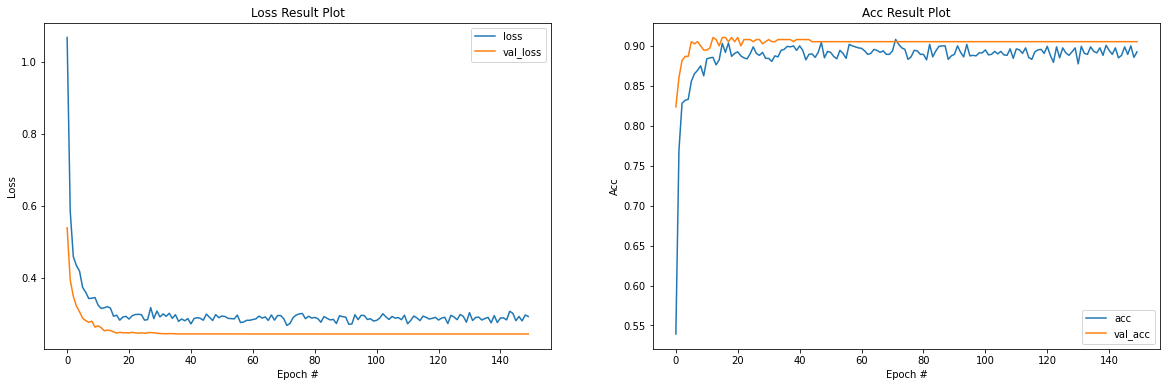

In [19]:
#plot model 1
fig, (plt1, plt2) = plt.subplots(1,2, figsize=(20,6)) #buat bikin subplot

plt1.figsize=(10,8)
plt1.plot(np.arange(0, 150), history.history["loss"], label="loss")
plt1.plot(np.arange(0, 150), history.history["val_loss"], label="val_loss")
plt1.set_title("Loss Result Plot")
plt1.set_xlabel("Epoch #")
plt1.set_ylabel("Loss")
plt1.legend()

plt2.figsize=(10,8)
plt2.plot(np.arange(0, 150), history.history["accuracy"], label="acc")
plt2.plot(np.arange(0, 150), history.history["val_accuracy"], label="val_acc")
plt2.set_title("Acc Result Plot")
plt2.set_xlabel("Epoch #")
plt2.set_ylabel("Acc")
plt2.legend()

In [20]:
#Evaluasi menggunakan classification report
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
from keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix

ypred = model2.predict(validation_generator)
prediction = np.argmax(ypred, axis=1)
print(classification_report(validation_generator.classes, prediction))

              precision    recall  f1-score   support

           0       0.82      0.84      0.83        95
           1       0.97      1.00      0.98        95
           2       0.97      0.99      0.98        95
           3       0.86      0.79      0.82        95

    accuracy                           0.91       380
   macro avg       0.90      0.91      0.90       380
weighted avg       0.90      0.91      0.90       380



Confusion matrix, without normalization
[[80  1  2 12]
 [ 0 95  0  0]
 [ 1  0 94  0]
 [17  2  1 75]]


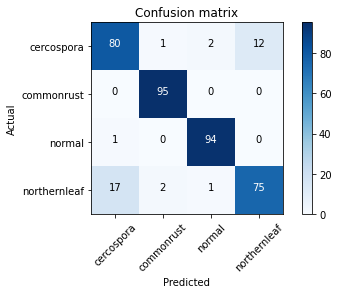

In [22]:
#Evaluasi menggunakan confusion matrix

import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Actual')
    plt.xlabel('Predicted')

cnf_matrix=confusion_matrix(validation_generator.classes,prediction)
plot_confusion_matrix(cnf_matrix, classes=validation_generator.class_indices)

In [23]:
model2.save("modelmod5.h5")